# DATA EXPLORATION

## Imports

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#### Data

In [0]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ",")\
    .load("dbfs:/FileStore/shared_uploads/amine.ait-amalik@ut-capitole.fr/tracks.csv")

In [0]:
df = df.toPandas()
df.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.0,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.177,1,-21.18,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918,0.104,0.397,169.98,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.158,3,-16.9,0,0.039,0.989,0.13,0.311,0.196,103.22,4


In [0]:
df.shape

Out[4]: (586672, 20)

### A) Data Cleaning

#### Variables of Interest

In [0]:
df = df[[
    "id", "name", "popularity", "duration_ms", "artists", "release_date", "danceability", "loudness", "tempo"
]]

### Missing Values Hunt

In [0]:
df.isna().sum()

Out[6]: id               0
name            71
popularity       0
duration_ms      0
artists          0
release_date    12
danceability    12
loudness        12
tempo           12
dtype: int64

Since there are only a few missing values, a deletion seems reasonable

In [0]:
df_no_na = df.dropna().reset_index().drop(columns="index")
df_no_na.isna().sum()

Out[7]: id              0
name            0
popularity      0
duration_ms     0
artists         0
release_date    0
danceability    0
loudness        0
tempo           0
dtype: int64

## B) Analysis

In [0]:
df_no_na["popularity"].describe()

Out[8]: count     586589
unique      1359
top            0
freq       44056
Name: popularity, dtype: object

Popularity ranges from 0 to 100

In [0]:
df_no_na["loudness"].describe()

Out[9]: count     586589
unique     29782
top            0
freq         257
Name: loudness, dtype: object

Loudness ranges from -60 to 5.37

In [0]:
df_no_na["duration_s"] = round(df_no_na["duration_ms"] / 1000)
df_no_na["duration_s"].describe()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/databricks/python/lib/python3.8/site-packages/pandas/core/ops/array_ops.py in _na_arithmetic_op(left, right, op, is_cmp)
    141     try:
--> 142         result = expressions.evaluate(op, left, right)
    143     except TypeError:

/databricks/python/lib/python3.8/site-packages/pandas/core/computation/expressions.py in evaluate(op, a, b, use_numexpr)
    234             # error: "None" not callable
--> 235             return _evaluate(op, op_str, a, b)  # type: ignore[misc]
    236     return _evaluate_standard(op, op_str, a, b)

/databricks/python/lib/python3.8/site-packages/pandas/core/computation/expressions.py in _evaluate_standard(op, op_str, a, b)
     68     with np.errstate(all="ignore"):
---> 69         return op(a, b)
     70 

TypeError: unsupported operand type(s) for /: 'str' and 'int'

During handling of the above excepti

Duration in seconds (instead of miliseconds) ranges from 3 to 5621 seconds

In [0]:
df_no_na["danceability"].describe()

Out[11]: count     586589
unique      2627
top        0.637
freq        1482
Name: danceability, dtype: object

Danceability ranges from 0 to 0.991

In [0]:
df_no_na["tempo"].describe()

Out[12]: count     586589
unique    123898
top          0.0
freq         364
Name: tempo, dtype: object

Tempo ranges from 0 to 246.381

### Expectations

- We expect danceability to be strongly positively correlated with popularity
- The opposite probably goes for duration since today, most mainstream artists favor short hits
- Release date probably has an influence, since older songs seem to die out bit by bit (though some unforgettable classics forever remain in our hearts)
- Linking popularity to loudness and tempo is a bit more tricky. Their relationship is surely non-linear

#### Popularity to a dummy variable with 1 meaning popularity is above 50 and 0 otherwise

In [0]:
df_no_na = df_no_na[df_no_na.popularity.apply(lambda x: x.isnumeric())]

In [0]:
fake_series = pd.Series(range(len(df_no_na)))

for i in range(len(df_no_na)):
    if df_no_na["popularity"][i] > 50:
        fake_series[i] = 1
    else:
        fake_series[i] = 0

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-4486224118267752> in <module>
      2 
      3 for i in range(len(df_no_na)):
----> 4     if df_no_na["popularity"][i] > 50:
      5         fake_series[i] = 1
      6     else:

TypeError: '>' not supported between instances of 'str' and 'int'

In [0]:
df_no_na["dummy_pop"] = fake_series

<command-4486224118267753>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na["dummy_pop"] = fake_series


### C) Variable distributions between Popular and Unpopular Music

In [0]:
df_pop = df_no_na[df_no_na["dummy_pop"] == 1].reset_index().drop(columns="index")
df_unpop = df_no_na[df_no_na["dummy_pop"] == 0].reset_index().drop(columns="index")

#### Loudness

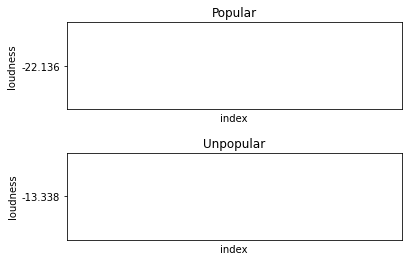

In [0]:
fig = plt.figure()

subplot1 = fig.add_subplot(2, 1, 1)
subplot1.plot(df_pop["loudness"])
#plt.ylim([-60, 5])
plt.xlabel("index")
plt.ylabel("loudness")
plt.title("Popular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)


subplot2=fig.add_subplot(2, 1, 2)
subplot2.plot(df_unpop["loudness"])
#plt.ylim([-60, 5])
plt.xlabel("index")
plt.ylabel("loudness")
plt.title("Unpopular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)


plt.subplots_adjust(
    hspace=0.5
)

In [0]:
plt.scatter(
    x=df_no_na["loudness"],
    y=df_no_na["popularity"]
)

plt.xlabel("loudness")
plt.ylabel("popularity")
plt.title("Popularity as a Function of Loudness")

Out[28]: Text(0.5, 1.0, 'Popularity as a Function of Loudness')

#### Danceability

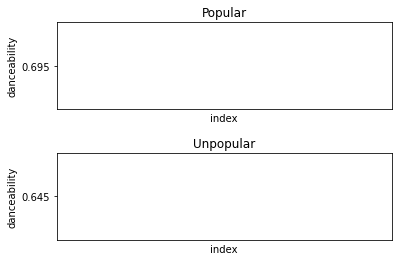

In [0]:
fig = plt.figure()

subplot1 = fig.add_subplot(2, 1, 1)
subplot1.plot(df_pop["danceability"])
#plt.ylim([-60, 5])
plt.xlabel("index")
plt.ylabel("danceability")
plt.title("Popular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)


subplot2=fig.add_subplot(2, 1, 2)
subplot2.plot(df_unpop["danceability"])
#plt.ylim([-60, 5])
plt.xlabel("index")
plt.ylabel("danceability")
plt.title("Unpopular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)


plt.subplots_adjust(
    hspace=0.5
)

In [0]:
plt.scatter(
    x=df_no_na["danceability"],
    y=df_no_na["popularity"]
)

plt.xlabel("danceability")
plt.ylabel("popularity")
plt.title("Popularity as a Function of Danceability")

Out[22]: Text(0.5, 1.0, 'Popularity as a Function of Danceability')

#### Tempo

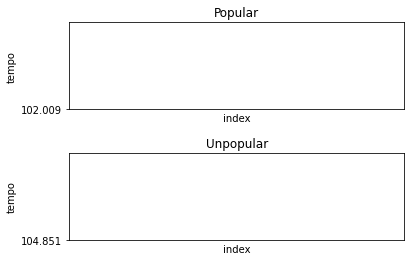

In [0]:
fig = plt.figure()

subplot1 = fig.add_subplot(2, 1, 1)
subplot1.plot(df_pop["tempo"])
plt.xlabel("index")
plt.ylabel("tempo")
plt.title("Popular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylim([0, 200])


subplot2=fig.add_subplot(2, 1, 2)
subplot2.plot(df_unpop["tempo"])
plt.xlabel("index")
plt.ylabel("tempo")
plt.title("Unpopular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylim([0, 200])


plt.subplots_adjust(
    hspace=0.5
)

In [0]:
plt.scatter(
    x=df_no_na["tempo"],
    y=df_no_na["popularity"]
)

plt.xlabel("tempo")
plt.ylabel("popularity")
plt.title("Popularity as a Function of Tempo")

Out[24]: Text(0.5, 1.0, 'Popularity as a Function of Tempo')

#### Duration

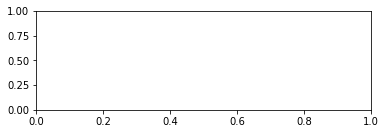

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/databricks/python/lib/python3.8/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   3079             try:
-> 3080                 return self._engine.get_loc(casted_key)
   3081             except KeyError as err:

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'duration_s'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
<command-4486224118267766> in <module>
      2 
      3 subplot1 = fig.add_subplot(2, 1, 1)
----> 4 

In [0]:
fig = plt.figure()

subplot1 = fig.add_subplot(2, 1, 1)
subplot1.plot(df_pop["duration_s"])
plt.xlabel("index")
plt.ylabel("duration_s")
plt.title("Popular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylim([0, 4500])


subplot2=fig.add_subplot(2, 1, 2)
subplot2.plot(df_unpop["duration_s"])
plt.xlabel("index")
plt.ylabel("duration_s")
plt.title("Unpopular")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylim([0, 4500])


plt.subplots_adjust(
    hspace=0.5
)

In [0]:
plt.scatter(
    x=df_no_na["duration_s"],
    y=df_no_na["popularity"]
)

plt.xlabel("duration_s")
plt.ylabel("popularity")
plt.title("Popularity as a Function of Duration in Seconds")

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/databricks/python/lib/python3.8/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   3079             try:
-> 3080                 return self._engine.get_loc(casted_key)
   3081             except KeyError as err:

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'duration_s'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
<command-4486224118267767> in <module>
      1 plt.scatter(
----> 2     x=df_no_na["duration_s"],
  